# Ames Housing - Jan Deknatel - Exercise 4 - dec 2020

Referencing following Kaggle notebooks:
- https://www.kaggle.com/leeclemmer/exploratory-data-analysis-of-housing-in-ames-iowa
- https://www.kaggle.com/agodwinp/stacking-house-prices-walkthrough-to-top-5

# Assignment

![](https://storage.googleapis.com/kaggle-competitions/kaggle/5407/media/housesbanner.png)

# Ames Housing dataset

Following Kaggle's [Getting Started Prediction Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), the goal for this discover project is to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

The performance metric for your prediction model is the _Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price_. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

Looking at the [public leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard), the top 2% have RMSLE of 0.00044, whilst 25th-percentile and and median performance is at 0.125 and 0.14, respectively.

As an extra challenge, you can try to trade-off the number of predictors (less is better) vs. performance. Can you make the top 10% (RMSLE 0.123) with the least number of predictors?

  
### Exercise 4 (rewritten based on feedback from Daniel Kapitan and own ideas)
  - Compare impact of 'simple','average' and 'full' feature engineering on final results (see sections A., B. & C.)
  - Compare LASSO and KNN model performance (see section D.)
  - Determine the lowest num of features using SelectKBest to reach top quart of ranking table (RMSE=0120?). (see section E.)
  - Apply PCA to determine if a lower amount can be achieved (see section F.)
  - Compare with Lasso feature selection (see section G.)
 
N.B.1 Train and test dataset are created from from full Amess Housing dataset using train_test_plit function (50-50 choosen to keep in line with Kaggle competition:

          X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)
      
      
N.B.2 Results of modelling are calculated for training and test dataset using cross validation score function 'rmse':

     def rmse(model, X_train, X_test, y_train, y_test):
        training_result = np.sqrt((-cross_val_score(model,X_train,y_train,cv=10,scoring='neg_mean_squared_error')).mean())
        test_result= np.sqrt(((y_test-model.predict(X_test))**2).mean())
        return training_result, test_result

N.B.3 The train and test datasets are split after missing values have been replaced with median. This is incorrect as it causes some limited leakage between train and test datasets. => To-Do list.

N.B.4 The impact of applying standardscaler on numeric features ahead of modeling still to be investigated. For PCA analysis the explained variance should be printed in results overview. => To-Do list.


 
#### A. 'Simple' feature engineering
  - Remove outliers as per description Ames Housing dataset
  - Delete all features with NA values
  - Create dummies for all categorical features
  - Take log transform of Sale Price 'Y'

#### B. 'Average' feature engineering
  - Remove outliers as per description Ames Housing dataset
  - Remove abnormal sales indicated by Sale Condition equals Abnorml
  - Replace all NA values with median (numeric) or "missing" (categoric)
  - Convert relevant numeric features to categoric and ordinal categoric feature to numeric as per example notebook.
  - Create dummies for all remaining categorical features
  - Take log transform of numeric features when skew > 0.75 including SalePrice

#### C. 'Full' feature engineering
  - Remove outliers as per description Ames Housing dataset
  - Remove abnormal sales indicated by Sale Condition equals Abnorml and Family
  - Create square, cubic and quadratic features of top-20 features as per example notebook. 
  - Create/convert features by combining or grouping features or values as per example notebook.
  - Convert relevant numeric features to categoric and ordinal categoric feature to numeric
  - Create dummies for all remaining categorical features
  - Take Log Transform of SalePrice
  - Take Box-Cox of numeric features when skew > 0.75 (includes SalePrice)

#### D. Comparing Lasso with KNN model
  - Compare Lasso with KNN model for a range K of nearest neighbors 
  
#### E. Determine minimum number of features to get a test RMSE of 0.120 using SelectKBest feature selection (result: 75 features).

#### F. Determine minimum number of features to get a test RMSE of 0.120 using PCA feature selection (result: 18 features).
  
#### G. Determine minimum number of features to get a test RMSE of 0.120 using Lasso feature selection (result: 19 features).
  
 

***

### Import libraries

In [1]:
import os
import warnings

import pandas as pd
print('\nUsing Pandas version\t',pd.__version__)

import numpy as np
from numpy import absolute
from numpy import mean
from numpy import std
print('Using Numpy version\t',np.version.version)

# Statistical packages used for transformations
from scipy.special import boxcox1p

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print('Using Matplotlib version',matplotlib.__version__)

import seaborn as sns
print('Using Seaborn version\t',sns.__version__)

import sklearn

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.decomposition import PCA
from sklearn import decomposition

print('Using ScikitLearn version', sklearn.__version__)



Using Pandas version	 1.0.5
Using Numpy version	 1.18.5
Using Matplotlib version 3.2.2
Using Seaborn version	 0.10.1
Using ScikitLearn version 0.23.1


# Exercise nr 4

### Defining a function to explore a dataframe and return categorized lists of features¶

In [2]:
def expl_df(df_input, name):
    
    """ Prints analysis of dataframe 'df_input' with name 'name' and returns lists of numeric, categorical, complete,
        incomplete features, features with many zeros and features with high skew > 0.75. """

    print('\n\033[1mDataframe analysis for dataframe:  ',name,'\033[0m')

    # Print dimensions of dataframe
    num_rows = df_input.shape[0]
    num_cols = df_input.shape[1]
    print('Dataframe',name,'has', num_rows, 'rows and', num_cols,'columns')

    # Check which features are numeric and which features are categorical 
    num_features = list(df_input.select_dtypes(include=['uint8','int64','float64']).columns)
    cat_features = list(df_input.select_dtypes(include=['object', 'category']).columns)
    print('Dataframe',name,'has', len(num_features) , 'numeric features and', len(cat_features),'categorical features')

    # Check which features have missing values and might need attention and print number of features
    count_values_feature=df_input.count()

    complete_features = list(count_values_feature[count_values_feature == num_rows].index)
    incomplete_features = list(count_values_feature[count_values_feature < num_rows].index)
    print('Dataframe',name,'has',len(complete_features), 'complete features and', len(incomplete_features),'incomplete features')
    
    # Calculate skew for each numeric feature and select features with skew>0.75 
    calc_skew_feature = df_input[num_features].skew()
    skew_features = list(calc_skew_feature[calc_skew_feature > 0.75].index)
    print('Dataframe',name,'has',len(skew_features), 'numeric features with a skew > 0.75')
    
    return num_features, cat_features, incomplete_features, complete_features, skew_features

### Defining a function to calculate model results on train and test datasets¶

In [3]:
#
# Function to score training and test datasets with cross validation
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
#
def rmse(model, X_train, X_test, y_train, y_test):
    training_result = np.sqrt((-cross_val_score(model, X_train, y_train, cv = 10, scoring= 'neg_mean_squared_error')).mean())
    # test_result = np.sqrt((-cross_val_score(model, X_test, y_test, cv = 10, scoring= 'neg_mean_squared_error')).mean())      
    test_result= np.sqrt(((y_test-model.predict(X_test))**2).mean()) # single     
    return training_result, test_result

### Defining functions to run Lasso model in single run and gridsearch mode

In [4]:
#
# Function to run single lasso model and print results 
#
def run_lasso(alpha, X_train, X_test, y_train, y_test):
    lasso = Lasso(alpha=alpha, max_iter=5000)
    lasso.fit(X_train, y_train)
    training_result, test_result = rmse(lasso, X_train, X_test, y_train, y_test)
    print('Model: Lasso |  alpha: {} \t| Dropped {} of {} features \t| Train RMSE: {:.3f} | Test RMSE: {:.3f}'.
          format(alpha, sum(lasso.coef_ ==0), len(lasso.coef_) , training_result, test_result))
    return

#
# Function to run lasso model in gridsearch with param_grid and print results 
#
def run_grid_lasso(param_grid):
    lasso = GridSearchCV(Lasso(), cv=2, param_grid=param_grid, scoring='neg_mean_squared_error')
    lasso.fit(X_train, y_train)
    alpha = lasso.best_params_['alpha']
    training_result, test_result = rmse(lasso, X_train, X_test, y_train, y_test)
    print('Model: Lasso | Alpha: {} \t| Train RMSE: {:.3f} | Test RMSE: {:.3f}'.
          format(alpha, training_result, test_result))
    return alpha

### Defining function to plot results of application of regression model

In [5]:
def model_evaluation_plots(model, X_train, y_train, X_test, y_test):
    y_train_preds = model.predict(X_train)
    y_test_preds = model.predict(X_test)
    
    plt.figure(figsize=(14,8))
    # Residuals
    plt.subplot(121)
    plt.scatter(y_train_preds, y_train_preds - y_train, c='blue', marker='.', label='Training data')
    plt.scatter(y_test_preds, y_test_preds - y_test, c='orange', marker='.', label='Test data')
    plt.title('Residuals')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin=y_train.min(), xmax=y_train.max(), color='red')

    # Predictions
    plt.subplot(122)
    plt.scatter(y_train_preds, y_train, c='blue', marker='.', label='Training data')
    plt.scatter(y_test_preds, y_test, c='orange', marker='.', label='Test data')
    plt.title('Predictions')
    plt.xlabel('Predicted values')
    plt.ylabel('Real values')
    plt.legend(loc='upper left')
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], c='red')
    plt.tight_layout()
    plt.show()
    return

# A. 'Simple' feature engineering
  - Remove outliers as per description Ames Housing dataset
  - Delete all features with NA values
  - Create dummies for all categorical features
  - Take log transform of Sale Price 'Y'

### Import full dataset in csv format

In [6]:
#
# Read full Ames housing dataset, drop columns 'Order' and 'PID'
#
df = pd.read_csv("https://raw.githubusercontent.com/knaat/Ames-housing/main/AmesHousing.csv")

# Drop columns 'Order' and 'PID'
df.drop(columns=['Order', 'PID'], inplace=True)

# Call defined function which explores dataframe and returns feature lists 
num_feat,cat_feat,incomp_feat,comp_feat,skew_feat = expl_df(df,'df')


Dataframe analysis for dataframe:   df 
Dataframe df has 2930 rows and 80 columns
Dataframe df has 37 numeric features and 43 categorical features
Dataframe df has 53 complete features and 27 incomplete features
Dataframe df has 23 numeric features with a skew > 0.75


### Apply 'simple' feature engineering 

In [7]:
# Change datatype from object to categorical for all columns in 'cat_feat' list.
for column in cat_feat:
    df[column] = pd.Categorical(df[column])

# Remove outliers as per description Ames Housing dataset
df.drop(df[df['Gr Liv Area'] >= 4000].index, inplace=True)

# Remove all features with NA values
df.drop(columns=incomp_feat, inplace=True)

# Create dummies for all categorical features
df_simple_feat_eng = pd.get_dummies(df).copy()

# Call defined function which explores dataframe and returns feature lists 
num_feat,cat_feat,incomp_feat,comp_feat,skew_feat = expl_df(df_simple_feat_eng,'df_simple_feat_eng')



Dataframe analysis for dataframe:   df_simple_feat_eng 
Dataframe df_simple_feat_eng has 2925 rows and 219 columns
Dataframe df_simple_feat_eng has 219 numeric features and 0 categorical features
Dataframe df_simple_feat_eng has 219 complete features and 0 incomplete features
Dataframe df_simple_feat_eng has 177 numeric features with a skew > 0.75


### Define training and test datasets and run Lasso model for range of alpha parameters followed by gridsearch

In [8]:
#
# Define feature set X and target y and split in random training and testing datasets
#
X= df_simple_feat_eng.drop(columns=['SalePrice']).copy()
y= np.log(df_simple_feat_eng['SalePrice']).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)


Simple feature engineering - Lasso model - trying a number of alpha values
Model: Lasso |  alpha: 0.1 	| Dropped 203 of 218 features 	| Train RMSE: 0.198 | Test RMSE: 0.168
Model: Lasso |  alpha: 0.01 	| Dropped 199 of 218 features 	| Train RMSE: 0.157 | Test RMSE: 0.132
Model: Lasso |  alpha: 0.001 	| Dropped 153 of 218 features 	| Train RMSE: 0.140 | Test RMSE: 0.117
Model: Lasso |  alpha: 0.0001 	| Dropped 63 of 218 features 	| Train RMSE: 0.144 | Test RMSE: 0.118

Simple feature engineering - Lasso model - using Gridsearch to determine optimum alpha
Model: Lasso | Alpha: 0.001 	| Train RMSE: 0.140 | Test RMSE: 0.117
Model: Lasso | Alpha: 0.0006 	| Train RMSE: 0.140 | Test RMSE: 0.115


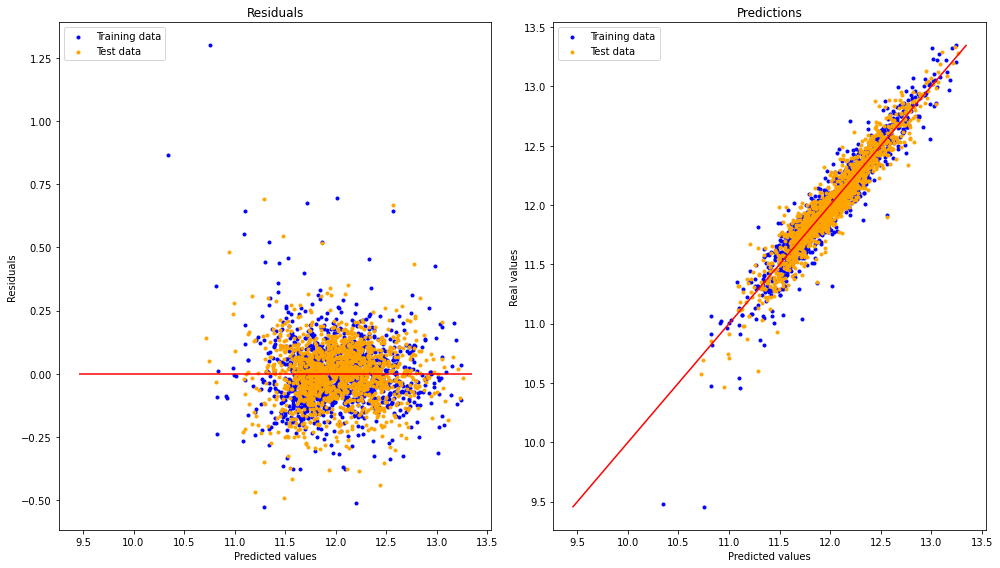

LASSO dropped 133 of 218 features.


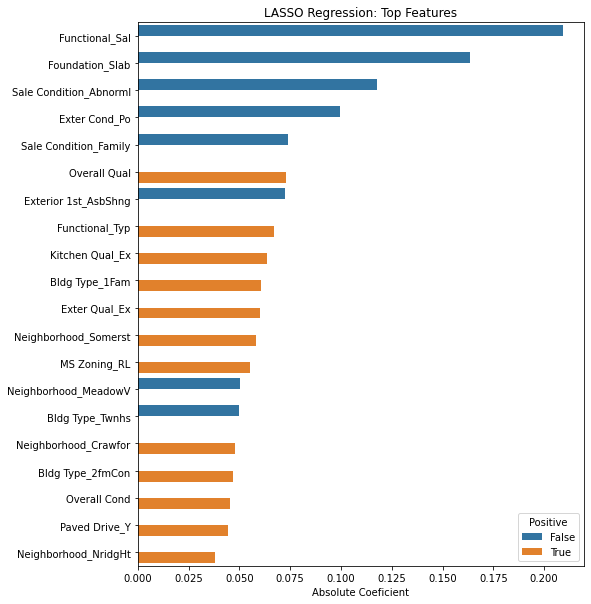

In [9]:
# 
# Run Lasso models for a range of alpha parameters and then do a gridsearch to get optimum alpha 
# 

print ('\n\033[1mSimple feature engineering - Lasso model - trying a number of alpha values\033[0m')
alpha=0.1
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.01
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.001
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.0001
run_lasso(alpha,X_train, X_test, y_train, y_test)
    
#
# Run a coarse and fine gridsearch for alpha parameter
#
print ('\n\033[1mSimple feature engineering - Lasso model - using Gridsearch to determine optimum alpha\033[0m')
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 10.], 'max_iter': [5000]} 
alpha = run_grid_lasso(param_grid)

param_grid = {'alpha': [x/100. * alpha for x in range(40, 160, 20)], 'max_iter': [5000]}  #finer search
final_alpha = run_grid_lasso(param_grid)

#
# Run lasso with final alpha and plot residuals and predictions 
#
lasso = Lasso(alpha=final_alpha, max_iter=5000)
lasso.fit(X_train, y_train)
model_evaluation_plots(lasso, X_train, y_train, X_test, y_test)

#
# Analyse Lasso coefficients
#
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('LASSO dropped {} of {} features.'.format(sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

## Analysis of Lasso model with 'Simple' feature engineering

Observations: 
   - The results for test dataset are better than for training dataset. This is most likely caused by 2 anomalous sales with low purchase price around log(SalePrice) = 9.5 
   - Lowest RMSE for test dataset is 0.115 which is pretty low considering the very basic feature engineering applied with 27 of the original features dropped due to missing value. 
   - Around 60% of the features get dropped by Lasso alogrithm
   - Surprising features in top 20 with 8 with a negative coeficient. 

***

# B. 'Average' feature engineering
  - Remove outliers as per description Ames Housing dataset
  - Remove abnormal sales indicated by Sale Condition equals Abnorml
  - Replace all NA values with median (numeric) or "missing" (categoric)
  - Convert relevant numeric features to categoric and ordinal categoric feature to numeric as per example notebook.
  - Create dummies for all remaining categorical features
  - Take log transform of numeric features when skew > 0.75 including SalePrice

### Import full dataset in csv format

In [10]:
#
# Read full Ames housing dataset, drop columns 'Order' and 'PID'
#
df = pd.read_csv("https://raw.githubusercontent.com/knaat/Ames-housing/main/AmesHousing.csv")

# Drop columns 'Order' and 'PID'
df.drop(columns=['Order', 'PID'], inplace=True)

# Call defined function which explores dataframe and returns feature lists 
num_feat,cat_feat,incomp_feat,comp_feat,skew_feat = expl_df(df,'df')


Dataframe analysis for dataframe:   df 
Dataframe df has 2930 rows and 80 columns
Dataframe df has 37 numeric features and 43 categorical features
Dataframe df has 53 complete features and 27 incomplete features
Dataframe df has 23 numeric features with a skew > 0.75


### Apply 'average' feature engineering  by Lee Clemmer (see reference)

In [11]:
# Remove outliers as per description Ames Housing dataset
df.drop(df[df['Gr Liv Area'] >= 4000].index, inplace=True)
    
# Remove Abnormal Sales with Sale Condition equals Abnorml 
df.drop(df[df['Sale Condition'] == 'Abnorml' ].index, inplace=True)

# 'Inner join' of numeric feature list and incomplete feature list 
num_incomp_feat = list( set(num_feat) & set(incomp_feat) )
# Fill all NA valuers with median value
for column in num_incomp_feat:
    df[column].fillna(df[column].median(), inplace=True)
    
# 'Inner join' of categorical feature list and incomplete feature list 
cat_incomp_feat = list( set(cat_feat) & set(incomp_feat) )
# Fill all NA valuers with "missing" value
for column in cat_incomp_feat:
    df[column].fillna('missing', inplace = True) 

# log transform of features with skew > 0.75. This include SalePrice (no need to transform again later).
for column in skew_feat:
    df.loc[:,column] = np.log(df[column]+0.00000001)
    
# Change datatype from object to categorical for all columns in 'cat_feat' list.
for column in cat_feat:
    df[column] = pd.Categorical(df[column])    
    

# Convert number of numeric features to categorical features
df['MS SubClass'] = df['MS SubClass'].apply(lambda x: str(x))
df['Mo Sold'] = df['Mo Sold'].apply(lambda x: str(x))
df['Yr Sold'] = df['Yr Sold'].apply(lambda x: str(x))

# Convert number of ordinal categoric features to numeric features
df['Alley'].replace({'Grvl':1, 'Pave':2}, inplace=True)
df['Lot Shape'].replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)
df['Land Contour'].replace({'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}, inplace=True)
df['Utilities'].replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)
df['Land Slope'].replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)
df['Exter Qual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df['Exter Cond'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df['Bsmt Qual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df['Bsmt Cond'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df['Bsmt Exposure'].replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)
df['BsmtFin Type 1'].replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
df['BsmtFin Type 2'].replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
df['Heating QC'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df['Kitchen Qual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df['Functional'].replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)
df['Fireplace Qu'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df['Garage Finish'].replace({'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)
df['Garage Qual'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df['Garage Cond'].replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
df['Paved Drive'].replace({'N':1, 'P':2, 'Y':3}, inplace=True)
df['Pool QC'].replace({'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)

# Set all missing values in our newly converted features to 0
converted_features = ['Alley','Lot Shape','Land Contour','Utilities','Land Slope','Exter Qual','Exter Cond',
        'Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC',
        'Kitchen Qual','Functional','Fireplace Qu','Garage Finish','Garage Qual',
        'Garage Cond','Paved Drive','Pool QC']
df[converted_features] = df[converted_features].fillna(0)

# Call defined function which explores dataframe and returns feature lists 
num_feat,cat_feat,incomp_feat,comp_feat,skew_feat = expl_df(df,'df')

# Change datatype from object to categorical for all columns in 'cat_feat' list.
for column in cat_feat:
    df[column] = pd.Categorical(df[column])    

# Create dummies for all categorical features
df_average_feat_eng = pd.get_dummies(df).copy()

# Call defined function which explores dataframe and returns feature lists 
num_feat,cat_feat,incomp_feat,comp_feat,skew_feat = expl_df(df_average_feat_eng,'df_average_feat_eng')



Dataframe analysis for dataframe:   df 
Dataframe df has 2736 rows and 80 columns
Dataframe df has 44 numeric features and 36 categorical features
Dataframe df has 80 complete features and 0 incomplete features
Dataframe df has 10 numeric features with a skew > 0.75

Dataframe analysis for dataframe:   df_average_feat_eng 
Dataframe df_average_feat_eng has 2736 rows and 311 columns
Dataframe df_average_feat_eng has 311 numeric features and 0 categorical features
Dataframe df_average_feat_eng has 311 complete features and 0 incomplete features
Dataframe df_average_feat_eng has 243 numeric features with a skew > 0.75


### Define training and test datasets and run Lasso model for range of alpha parameters followed by gridsearch

In [12]:
#
# Define feature set X and target y and split in random training and testing datasets
#
X= df_average_feat_eng.drop(columns=['SalePrice']).copy()
y= df_average_feat_eng['SalePrice'].copy() # SalePrice was already log transformed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)


Average feature engineering - Lasso model - trying a number of alpha values
Model: Lasso |  alpha: 0.1 	| Dropped 298 of 310 features 	| Train RMSE: 0.206 | Test RMSE: 0.212
Model: Lasso |  alpha: 0.01 	| Dropped 286 of 310 features 	| Train RMSE: 0.127 | Test RMSE: 0.132
Model: Lasso |  alpha: 0.001 	| Dropped 237 of 310 features 	| Train RMSE: 0.104 | Test RMSE: 0.105
Model: Lasso |  alpha: 0.0001 	| Dropped 113 of 310 features 	| Train RMSE: 0.111 | Test RMSE: 0.102

Average feature engineering - Lasso model - using Gridsearch to determine optimum alpha
Model: Lasso | Alpha: 0.001 	| Train RMSE: 0.104 | Test RMSE: 0.105
Model: Lasso | Alpha: 0.0008 	| Train RMSE: 0.107 | Test RMSE: 0.104


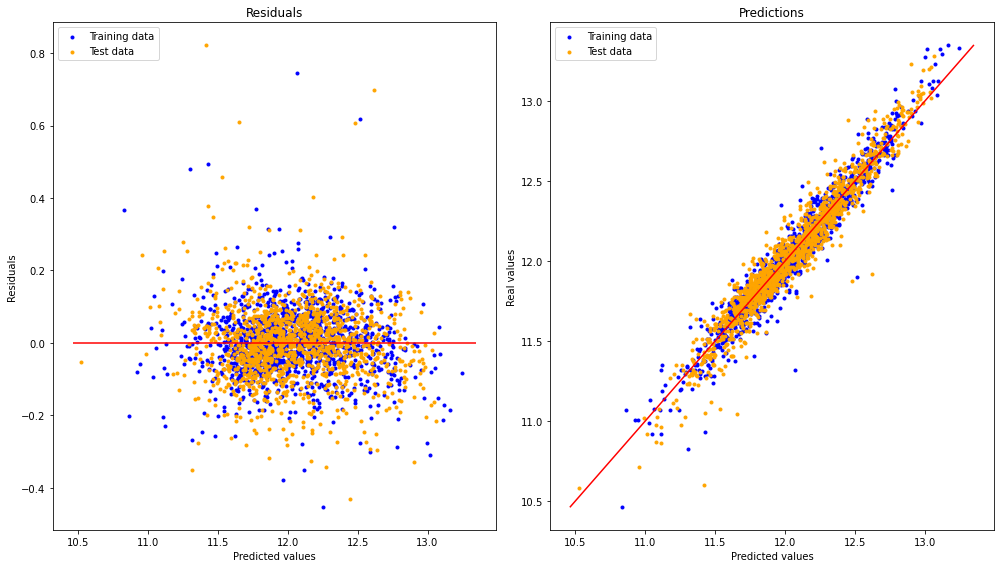

LASSO dropped 219 of 310 features.


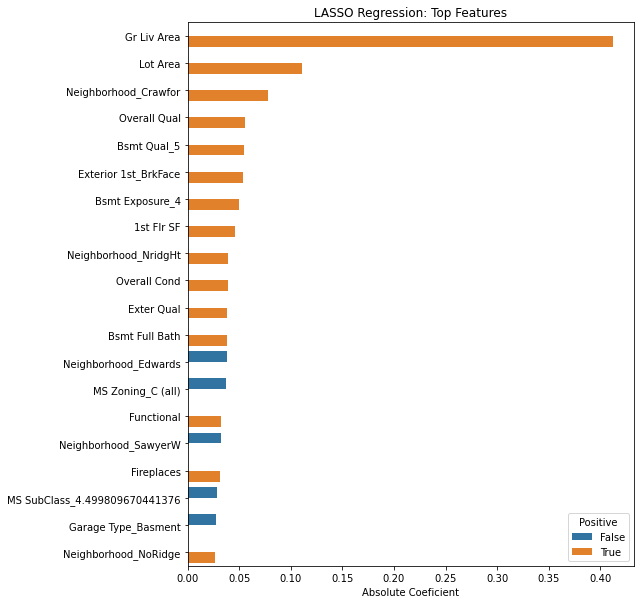

In [13]:
# 
# Run Lasso models for a range of alpha parameters and then do a gridsearch to get optimum alpha 
# 

print ('\n\033[1mAverage feature engineering - Lasso model - trying a number of alpha values\033[0m')
alpha=0.1
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.01
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.001
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.0001
run_lasso(alpha,X_train, X_test, y_train, y_test)
    
#
# Run a coarse and fine gridserach for alpha parameter
#
print ('\n\033[1mAverage feature engineering - Lasso model - using Gridsearch to determine optimum alpha\033[0m')
param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1., 10.], 'max_iter': [5000]} # coarse search
alpha = run_grid_lasso(param_grid)

param_grid = {'alpha': [x/100. * alpha for x in range(40, 160, 20)], 'max_iter': [5000]}  #finer search
final_alpha = run_grid_lasso(param_grid)

#
# Run lasso with final alpha and plot residuals and predictions 
#
lasso = Lasso(alpha=final_alpha, max_iter=5000)
lasso.fit(X_train, y_train)
model_evaluation_plots(lasso, X_train, y_train, X_test, y_test)

#
# Analyse Lasso coefficients
#
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('LASSO dropped {} of {} features.'.format(sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

## Analysis of Lasso model with 'Average' feature engineering

Observations: 
   - The results for test dataset are at same level as training dataset. Removal of abnormal sales has eliminated outliers with very low sales price.  
   - Lowest RMSE for test dataset is 0.102. Limited impact of the effort on feature engineering
   - Around 70% of the features get dropped by Lasso alogrithm
   - Features in top 20 more in line with expectation e.g Gr Liv Area and Lot Area. 5 features with a negative coeficient.
   - A small number of points line up on a linear trend below the y_pred = y line. Maybe linked to Family Sale Type. Remove in full feature engineering. 
   

***

# C. 'Full' feature engineering
  - Remove outliers as per description Ames Housing dataset
  - Remove abnormal sales indicated by Sale Condition equals Abnorml and Family
  - Create square, cubic and quadratic features of top-20 features as per example notebook. 
  - Create/convert features by combining or grouping features or values as per example notebook.
  - Convert relevant numeric features to categoric and ordinal categoric feature to numeric
  - Create dummies for all remaining categorical features
  - Take Log Transform of SalePrice
  - Take Box-Cox of numeric features when skew > 0.75 (includes SalePrice)
  


### Import full dataset in csv format

In [14]:
#
# Read full Ames housing dataset, drop columns 'Order' and 'PID'
#
df = pd.read_csv("https://raw.githubusercontent.com/knaat/Ames-housing/main/AmesHousing.csv")

# Drop columns 'Order' and 'PID'
df.drop(columns=['Order', 'PID'], inplace=True)

# Call defined function which explores dataframe and returns feature lists 
num_feat,cat_feat,incomp_feat,comp_feat,skew_feat = expl_df(df,'df')


Dataframe analysis for dataframe:   df 
Dataframe df has 2930 rows and 80 columns
Dataframe df has 37 numeric features and 43 categorical features
Dataframe df has 53 complete features and 27 incomplete features
Dataframe df has 23 numeric features with a skew > 0.75


### Apply 'full' feature engineering adapted from notebook by Arun Godwin Patel (see reference)

In [15]:
# Using data description, fill these missing values with "None"
for col in ("Pool QC", "Misc Feature", "Alley", "Fence", "Fireplace Qu",
           "Garage Type", "Garage Finish", "Garage Qual", "Garage Cond",
           "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1",
            "BsmtFin Type 2", "MS SubClass", "Mas Vnr Type"):
    df[col] = df[col].fillna("None")



# Using data description, fill these missing values with 0 
for col in ("Garage Yr Blt", "Garage Area", "Garage Cars", "BsmtFin SF 1", 
           "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "Mas Vnr Area",
           "Bsmt Full Bath", "Bsmt Half Bath"):
    df[col] = df[col].fillna(0)



# Fill these features with their mode, the most commonly occuring value. 
# This is okay since there are a low number of missing values for these features
df['Lot Frontage'] = df['Lot Frontage'].fillna(df['Lot Frontage'].mode()[0])
df['MS Zoning'] = df['MS Zoning'].fillna(df['MS Zoning'].mode()[0])
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['Kitchen Qual'] = df['Kitchen Qual'].fillna(df['Kitchen Qual'].mode()[0])
df['Exterior 1st'] = df['Exterior 1st'].fillna(df['Exterior 1st'].mode()[0])
df['Exterior 2nd'] = df['Exterior 2nd'].fillna(df['Exterior 2nd'].mode()[0])
df['Sale Type'] = df['Sale Type'].fillna(df['Sale Type'].mode()[0])
df["Functional"] = df["Functional"].fillna(df['Functional'].mode()[0])
df_na = df.isnull().sum()

# Remove outliers as per description Ames Housing dataset
df.drop(df[df['Gr Liv Area'] >= 4000].index, inplace=True)

# Remove Abnormal and Family Sales with Sale Condition equals Abnorml or Family 
df.drop(df[df['Sale Condition'] == 'Abnorml'  ].index, inplace=True)
df.drop(df[df['Sale Condition'] == 'Family'  ].index, inplace=True)

# Remove Utilities feature
df = df.drop(['Utilities'], axis=1)

# Call defined function which explores dataframe and returns feature lists 
num_feat,cat_feat,incomp_feat,comp_feat,skew_feat = expl_df(df,'df')

# Quadratic
df["OverallQual-2"] = df["Overall Qual"] ** 2
df["GrLivArea-2"] = df["Gr Liv Area"] ** 2
df["GarageCars-2"] = df["Garage Cars"] ** 2
df["Garage Area-2"] = df["Garage Area"] ** 2
df["TotalBsmtSF-2"] = df["Total Bsmt SF"] ** 2
df["1stFlrSF-2"] = df["1st Flr SF"] ** 2
df["FullBath-2"] = df["Full Bath"] ** 2
df["TotRmsAbvGrd-2"] = df["TotRms AbvGrd"] ** 2
df["Fireplaces-2"] = df["Fireplaces"] ** 2
df["MasVnrArea-2"] = df["Mas Vnr Area"] ** 2
df["BsmtFinSF1-2"] = df["BsmtFin SF 1"] ** 2
df["LotFrontage-2"] = df["Lot Frontage"] ** 2
df["WoodDeckSF-2"] = df["Wood Deck SF"] ** 2
df["OpenPorchSF-2"] = df["Open Porch SF"] ** 2
df["2ndFlrSF-2"] = df["2nd Flr SF"] ** 2

# Cubic
df["OverallQual-3"] = df["Overall Qual"] ** 3
df["GrLivArea-3"] = df["Gr Liv Area"] ** 3
df["GarageCars-3"] = df["Garage Cars"] ** 3
df["Garage Area-3"] = df["Garage Area"] ** 3
df["TotalBsmtSF-3"] = df["Total Bsmt SF"] ** 3
df["1stFlrSF-3"] = df["1st Flr SF"] ** 3
df["FullBath-3"] = df["Full Bath"] ** 3
df["TotRmsAbvGrd-3"] = df["TotRms AbvGrd"] ** 3
df["Fireplaces-3"] = df["Fireplaces"] ** 3
df["MasVnrArea-3"] = df["Mas Vnr Area"] ** 3
df["BsmtFinSF1-3"] = df["BsmtFin SF 1"] ** 3
df["LotFrontage-3"] = df["Lot Frontage"] ** 3
df["WoodDeckSF-3"] = df["Wood Deck SF"] ** 3
df["OpenPorchSF-3"] = df["Open Porch SF"] ** 3
df["2ndFlrSF-3"] = df["2nd Flr SF"] ** 3

# Square Root
df["OverallQual-Sq"] = np.sqrt(df["Overall Qual"])
df["GrLivArea-Sq"] = np.sqrt(df["Gr Liv Area"])
df["GarageCars-Sq"] = np.sqrt(df["Garage Cars"])
df["Garage Area-Sq"] = np.sqrt(df["Garage Area"])
df["TotalBsmtSF-Sq"] = np.sqrt(df["Total Bsmt SF"])
df["1stFlrSF-Sq"] = np.sqrt(df["1st Flr SF"])
df["FullBath-Sq"] = np.sqrt(df["Full Bath"])
df["TotRmsAbvGrd-Sq"] = np.sqrt(df["TotRms AbvGrd"])
df["Fireplaces-Sq"] = np.sqrt(df["Fireplaces"])
df["MasVnrArea-Sq"] = np.sqrt(df["Mas Vnr Area"])
df["BsmtFinSF1-Sq"] = np.sqrt(df["BsmtFin SF 1"])
df["LotFrontage-Sq"] = np.sqrt(df["Lot Frontage"])
df["WoodDeckSF-Sq"] = np.sqrt(df["Wood Deck SF"])
df["OpenPorchSF-Sq"] = np.sqrt(df["Open Porch SF"])
df["2ndFlrSF-Sq"] = np.sqrt(df["2nd Flr SF"])

df['Bsmt Qual'] = df['Bsmt Qual'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
df['Bsmt Cond'] = df['Bsmt Cond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
df['Bsmt Exposure'] = df['Bsmt Exposure'].map({"None":0, "No":1, "Mn":2, "Av":3, "Gd":4})

df = pd.get_dummies(df, columns = ["BsmtFin Type 1"], prefix="BsmtFin Type 1")

df.loc[df['BsmtFin SF 1']<=1002.5, 'BsmtFin SF 1'] = 1
df.loc[(df['BsmtFin SF 1']>1002.5) & (df['BsmtFin SF 1']<=2005), 'BsmtFin SF 1'] = 2
df.loc[(df['BsmtFin SF 1']>2005) & (df['BsmtFin SF 1']<=3007.5), 'BsmtFin SF 1'] = 3
df.loc[df['BsmtFin SF 1']>3007.5, 'BsmtFin SF 1'] = 4
df['BsmtFin SF 1'] = df['BsmtFin SF 1'].astype(int)
df = pd.get_dummies(df, columns = ["BsmtFin SF 1"], prefix="BsmtFin SF 1")

df = pd.get_dummies(df, columns = ["BsmtFin Type 2"], prefix="BsmtFin Type 2")

df['BsmtFinSf2_Flag'] = df['BsmtFin SF 2'].map(lambda x:0 if x==0 else 1)
df.drop('BsmtFin SF 2', axis=1, inplace=True)

df.loc[df['Bsmt Unf SF']<=778.667, 'Bsmt Unf SF'] = 1
df.loc[(df['Bsmt Unf SF']>778.667) & (df['Bsmt Unf SF']<=1557.333), 'Bsmt Unf SF'] = 2
df.loc[df['Bsmt Unf SF']>1557.333, 'Bsmt Unf SF'] = 3
df['Bsmt Unf SF'] = df['Bsmt Unf SF'].astype(int)
df = pd.get_dummies(df, columns = ["Bsmt Unf SF"], prefix="Bsmt Unf SF")

df.loc[df['1st Flr SF']<=1127.5, '1st Flr SF'] = 1
df.loc[(df['1st Flr SF']>1127.5) & (df['1st Flr SF']<=1921), '1st Flr SF'] = 2
df.loc[(df['1st Flr SF']>1921) & (df['1st Flr SF']<=2714.5), '1st Flr SF'] = 3
df.loc[(df['1st Flr SF']>2714.5) & (df['1st Flr SF']<=3508), '1st Flr SF'] = 4
df.loc[(df['1st Flr SF']>3508) & (df['1st Flr SF']<=4301.5), '1st Flr SF'] = 5
df.loc[df['1st Flr SF']>4301.5, '1st Flr SF'] = 6
df['1st Flr SF'] = df['1st Flr SF'].astype(int)
df = pd.get_dummies(df, columns = ["1st Flr SF"], prefix="1st Flr SF")

df.loc[df['2nd Flr SF']<=310.333, '2nd Flr SF'] = 1
df.loc[(df['2nd Flr SF']>310.333) & (df['2nd Flr SF']<=620.667), '2nd Flr SF'] = 2
df.loc[(df['2nd Flr SF']>620.667) & (df['2nd Flr SF']<=931), '2nd Flr SF'] = 3
df.loc[(df['2nd Flr SF']>931) & (df['2nd Flr SF']<=1241.333), '2nd Flr SF'] = 4
df.loc[(df['2nd Flr SF']>1241.333) & (df['2nd Flr SF']<=1551.667), '2nd Flr SF'] = 5
df.loc[df['2nd Flr SF']>1551.667, '2nd Flr SF'] = 6
df['2nd Flr SF'] = df['2nd Flr SF'].astype(int)
df = pd.get_dummies(df, columns = ["2nd Flr SF"], prefix="2nd Flr SF")

df['LowQualFinSF_Flag'] = df['Low Qual Fin SF'].map(lambda x:0 if x==0 else 1)
df.drop('Low Qual Fin SF', axis=1, inplace=True)

df['TotalBathrooms'] = df['Bsmt Half Bath'] + df['Bsmt Full Bath'] + df['Half Bath'] + df['Full Bath']

columns = ['Bsmt Half Bath', 'Bsmt Full Bath', 'Half Bath', 'Full Bath']
df.drop(columns, axis=1, inplace=True)

df['Kitchen Qual'] = df['Kitchen Qual'].map({"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})
df['Fireplace Qu'] = df['Fireplace Qu'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

df.loc[df['Gr Liv Area']<=1127.5, 'Gr Liv Area'] = 1
df.loc[(df['Gr Liv Area']>1127.5) & (df['Gr Liv Area']<=1921), 'Gr Liv Area'] = 2
df.loc[(df['Gr Liv Area']>1921) & (df['Gr Liv Area']<=2714.5), 'Gr Liv Area'] = 3
df.loc[(df['Gr Liv Area']>2714.5) & (df['Gr Liv Area']<=3508), 'Gr Liv Area'] = 4
df.loc[(df['Gr Liv Area']>3508) & (df['Gr Liv Area']<=4301.5), 'Gr Liv Area'] = 5
df.loc[df['Gr Liv Area']>4301.5, 'Gr Liv Area'] = 6
df['Gr Liv Area'] = df['Gr Liv Area'].astype(int)
df = pd.get_dummies(df, columns = ["Gr Liv Area"], prefix="Gr Liv Area")

df['MS SubClass'] = df['MS SubClass'].astype(str)
df = pd.get_dummies(df, columns = ["MS SubClass"], prefix="MS SubClass")

df['Bldg Type'] = df['Bldg Type'].astype(str)
df = pd.get_dummies(df, columns = ["Bldg Type"], prefix="Bldg Type")


df['House Style'] = df['House Style'].map({"2Story":"2Story", "1Story":"1Story", "1.5Fin":"1.5Story", "1.5Unf":"1.5Story", 
                                                     "SFoyer":"SFoyer", "SLvl":"SLvl", "2.5Unf":"2.5Story", "2.5Fin":"2.5Story"})
df = pd.get_dummies(df, columns = ["House Style"], prefix="House Style")

df['Remod_Diff'] = df['Year Remod/Add'] - df['Year Built']
df.drop('Year Remod/Add', axis=1, inplace=True)

df.loc[df['Year Built']<=1892, 'Year Built'] = 1
df.loc[(df['Year Built']>1892) & (df['Year Built']<=1911), 'Year Built'] = 2
df.loc[(df['Year Built']>1911) & (df['Year Built']<=1931), 'Year Built'] = 3
df.loc[(df['Year Built']>1931) & (df['Year Built']<=1951), 'Year Built'] = 4
df.loc[(df['Year Built']>1951) & (df['Year Built']<=1971), 'Year Built'] = 5
df.loc[(df['Year Built']>1971) & (df['Year Built']<=1990), 'Year Built'] = 6
df.loc[df['Year Built']>1990, 'Year Built'] = 7
df['Year Built'] = df['Year Built'].astype(int)
df = pd.get_dummies(df, columns = ["Year Built"], prefix="Year Built")

df = pd.get_dummies(df, columns = ["Foundation"], prefix="Foundation")

df['Functional'] = df['Functional'].map({"Sev":1, "Maj2":2, "Maj1":3, "Mod":4, "Min2":5, "Min1":6, "Typ":7, "Sal":8})

df = pd.get_dummies(df, columns = ["Roof Style"], prefix="Roof Style")
df = pd.get_dummies(df, columns = ["Roof Matl"], prefix="Roof Matl")

def Exter2(col):
    if col['Exterior 2nd'] == col['Exterior 1st']:
        return 1
    else:
        return 0
df['ExteriorMatch_Flag'] = df.apply(Exter2, axis=1)
df.drop('Exterior 2nd', axis=1, inplace=True)
df = pd.get_dummies(df, columns = ["Exterior 1st"], prefix="Exterior 1st")

df = pd.get_dummies(df, columns = ["Mas Vnr Type"], prefix="Mas Vnr Type")
df.drop('Mas Vnr Area', axis=1, inplace=True)

df['Exter Qual'] = df['Exter Qual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})

df = pd.get_dummies(df, columns = ["Exter Cond"], prefix="Exter Cond")

df = pd.get_dummies(df, columns = ["Garage Type"], prefix="Garage Type")

df.loc[df['Garage Yr Blt']<=1964, 'Garage Yr Blt'] = 1
df.loc[(df['Garage Yr Blt']>1964) & (df['Garage Yr Blt']<=1996), 'Garage Yr Blt'] = 2
df.loc[df['Garage Yr Blt']>1996, 'Garage Yr Blt'] = 3
df['Garage Yr Blt'] = df['Garage Yr Blt'].astype(int)

df = pd.get_dummies(df, columns = ["Garage Yr Blt"], prefix="Garage Yr Blt")

df = pd.get_dummies(df, columns = ["Garage Finish"], prefix="Garage Finish")

df.loc[df['Garage Area']<=496, 'Garage Area'] = 1
df.loc[(df['Garage Area']>496) & (df['Garage Area']<=992), 'Garage Area'] = 2
df.loc[df['Garage Area']>992, 'Garage Area'] = 3
df['Garage Area'] = df['Garage Area'].astype(int)
df = pd.get_dummies(df, columns = ["Garage Area"], prefix="Garage Area")

df['Garage Qual'] = df['Garage Qual'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
df = pd.get_dummies(df, columns = ["Garage Qual"], prefix="Garage Qual")

df['Garage Cond'] = df['Garage Cond'].map({"None":"None", "Po":"Low", "Fa":"Low", "TA":"TA", "Gd":"High", "Ex":"High"})
df = pd.get_dummies(df, columns = ["Garage Cond"], prefix="Garage Cond")

def WoodDeckFlag(col):
    if col['Wood Deck SF'] == 0:
        return 1
    else:
        return 0
df['NoWoodDeck_Flag'] = df.apply(WoodDeckFlag, axis=1)

df.loc[df['Wood Deck SF']<=356, 'Wood Deck SF'] = 1
df.loc[(df['Wood Deck SF']>356) & (df['Wood Deck SF']<=712), 'Wood Deck SF'] = 2
df.loc[(df['Wood Deck SF']>712) & (df['Wood Deck SF']<=1068), 'Wood Deck SF'] = 3
df.loc[df['Wood Deck SF']>1068, 'Wood Deck SF'] = 4
df['Wood Deck SF'] = df['Wood Deck SF'].astype(int)
df = pd.get_dummies(df, columns = ["Wood Deck SF"], prefix="Wood Deck SF")

df['TotalPorchSF'] = df['Open Porch SF'] + df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch'] 
def PorchFlag(col):
    if col['TotalPorchSF'] == 0:
        return 1
    else:
        return 0
df['NoPorch_Flag'] = df.apply(PorchFlag, axis=1)

df.loc[df['TotalPorchSF']<=431, 'TotalPorchSF'] = 1
df.loc[(df['TotalPorchSF']>431) & (df['TotalPorchSF']<=862), 'TotalPorchSF'] = 2
df.loc[(df['TotalPorchSF']>862) & (df['TotalPorchSF']<=1293), 'TotalPorchSF'] = 3
df.loc[df['TotalPorchSF']>1293, 'TotalPorchSF'] = 4
df['TotalPorchSF'] = df['TotalPorchSF'].astype(int)
df = pd.get_dummies(df, columns = ["TotalPorchSF"], prefix="TotalPorchSF")

def PoolFlag(col):
    if col['Pool Area'] == 0:
        return 0
    else:
        return 1
    
df['HasPool_Flag'] = df.apply(PoolFlag, axis=1)
df.drop('Pool Area', axis=1, inplace=True)

df.drop('Pool QC', axis=1, inplace=True)

df = pd.get_dummies(df, columns = ["Fence"], prefix="Fence")
df = pd.get_dummies(df, columns = ["MS Zoning"], prefix="MS Zoning")
df = pd.get_dummies(df, columns = ["Neighborhood"], prefix="Neighborhood")

df['Condition 1'] = df['Condition 1'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
df['Condition 2'] = df['Condition 2'].map({"Norm":"Norm", "Feedr":"Street", "PosN":"Pos", "Artery":"Street", "RRAe":"Train",
                                                    "RRNn":"Train", "RRAn":"Train", "PosA":"Pos", "RRNe":"Train"})
def ConditionMatch(col):
    if col['Condition 1'] == col['Condition 2']:
        return 0
    else:
        return 1
df['Diff2ndCondition_Flag'] = df.apply(ConditionMatch, axis=1)
df.drop('Condition 2', axis=1, inplace=True)
df = pd.get_dummies(df, columns = ["Condition 1"], prefix="Condition 1")


df.loc[df['Lot Area']<=5684.75, 'Lot Area'] = 1
df.loc[(df['Lot Area']>5684.75) & (df['Lot Area']<=7474), 'Lot Area'] = 2
df.loc[(df['Lot Area']>7474) & (df['Lot Area']<=8520), 'Lot Area'] = 3
df.loc[(df['Lot Area']>8520) & (df['Lot Area']<=9450), 'Lot Area'] = 4
df.loc[(df['Lot Area']>9450) & (df['Lot Area']<=10355.25), 'Lot Area'] = 5
df.loc[(df['Lot Area']>10355.25) & (df['Lot Area']<=11554.25), 'Lot Area'] = 6
df.loc[(df['Lot Area']>11554.25) & (df['Lot Area']<=13613), 'Lot Area'] = 7
df.loc[df['Lot Area']>13613, 'Lot Area'] = 8
df['Lot Area'] = df['Lot Area'].astype(int)
df = pd.get_dummies(df, columns = ["Lot Area"], prefix="Lot Area")

df = pd.get_dummies(df, columns = ["Lot Shape"], prefix="Lot Shape")
df = pd.get_dummies(df, columns = ["Land Contour"], prefix="Land Contour")

df['Lot Config'] = df['Lot Config'].map({"Inside":"Inside", "FR2":"FR", "Corner":"Corner", "CulDSac":"CulDSac", "FR3":"FR"})
df = pd.get_dummies(df, columns = ["Lot Config"], prefix="Lot Config")

df['Land Slope'] = df['Land Slope'].map({"Gtl":1, "Mod":2, "Sev":2})

def Slope(col):
    if col['Land Slope'] == 1:
        return 1
    else:
        return 0
    
df['GentleSlope_Flag'] = df.apply(Slope, axis=1)
df.drop('Land Slope', axis=1, inplace=True)

df.drop('Street', axis=1, inplace=True)

df = pd.get_dummies(df, columns = ["Alley"], prefix="Alley")
df = pd.get_dummies(df, columns = ["Paved Drive"], prefix="Paved Drive")

df['GasA_Flag'] = df['Heating'].map({"GasA":1, "GasW":0, "Grav":0, "Wall":0, "OthW":0, "Floor":0})
df.drop('Heating', axis=1, inplace=True)

df['Heating QC'] = df['Heating QC'].map({"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})

df['Central Air'] = df['Central Air'].map({"Y":1, "N":0})

df['Electrical'] = df['Electrical'].map({"SBrkr":"SBrkr", "FuseF":"Fuse", "FuseA":"Fuse", "FuseP":"Fuse", "Mix":"Mix"})
df = pd.get_dummies(df, columns = ["Electrical"], prefix="Electrical")

columns=['Misc Feature', 'Misc Val']
df.drop(columns, axis=1, inplace=True)

df = pd.get_dummies(df, columns = ["Mo Sold"], prefix="Mo Sold")

df = pd.get_dummies(df, columns = ["Yr Sold"], prefix="Yr Sold")

df['Sale Type'] = df['Sale Type'].map({"WD":"WD", "New":"New", "COD":"COD", "CWD":"CWD", "ConLD":"Oth", "ConLI":"Oth", 
                                                 "ConLw":"Oth", "Con":"Oth", "Oth":"Oth"})
df = pd.get_dummies(df, columns = ["Sale Type"], prefix="Sale Type")
df = pd.get_dummies(df, columns = ["Sale Condition"], prefix="Sale Condition")

# Log transform of SalePrice
df['SalePrice'] = np.log(df['SalePrice'])

# Call defined function which explores dataframe and returns feature lists 
num_feat,cat_feat,incomp_feat,comp_feat,skew_feat = expl_df(df,'df')

# Calculate Box-Cox transform of all other skew features
lam = 0.15
for column in skew_feat:
    df[column] = boxcox1p(df[column], lam)

# Copy to new dataframe
df_full_feat_eng = df.copy()

# Call defined function which explores dataframe and returns feature lists 
num_feat,cat_feat,incomp_feat,comp_feat,skew_feat = expl_df(df_full_feat_eng,'df_full_feat_eng')



Dataframe analysis for dataframe:   df 
Dataframe df has 2690 rows and 79 columns
Dataframe df has 37 numeric features and 42 categorical features
Dataframe df has 79 complete features and 0 incomplete features
Dataframe df has 21 numeric features with a skew > 0.75

Dataframe analysis for dataframe:   df 
Dataframe df has 2690 rows and 322 columns
Dataframe df has 322 numeric features and 0 categorical features
Dataframe df has 322 complete features and 0 incomplete features
Dataframe df has 247 numeric features with a skew > 0.75

Dataframe analysis for dataframe:   df_full_feat_eng 
Dataframe df_full_feat_eng has 2690 rows and 322 columns
Dataframe df_full_feat_eng has 322 numeric features and 0 categorical features
Dataframe df_full_feat_eng has 322 complete features and 0 incomplete features
Dataframe df_full_feat_eng has 217 numeric features with a skew > 0.75


### Define training and test datasets and run Lasso model for range of alpha parameters

In [16]:
#
# Define feature set X and target y and split in random training and testing datasets
#
X= df_full_feat_eng.drop(columns=['SalePrice']).copy()
y= df_full_feat_eng['SalePrice'].copy() # SalePrice was already log transformed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)


Full feature engineering - Lasso model - trying a number of alpha values
Model: Lasso |  alpha: 0.01 	| Dropped 299 of 321 features 	| Train RMSE: 0.117 | Test RMSE: 0.125
Model: Lasso |  alpha: 0.001 	| Dropped 246 of 321 features 	| Train RMSE: 0.099 | Test RMSE: 0.102
Model: Lasso |  alpha: 0.0005 	| Dropped 212 of 321 features 	| Train RMSE: 0.096 | Test RMSE: 0.099
Model: Lasso |  alpha: 0.0001 	| Dropped 123 of 321 features 	| Train RMSE: 0.095 | Test RMSE: 0.098
Model: Lasso |  alpha: 5e-05 	| Dropped 93 of 321 features 	| Train RMSE: 0.096 | Test RMSE: 0.099
Model: Lasso |  alpha: 1e-05 	| Dropped 63 of 321 features 	| Train RMSE: 0.097 | Test RMSE: 0.103


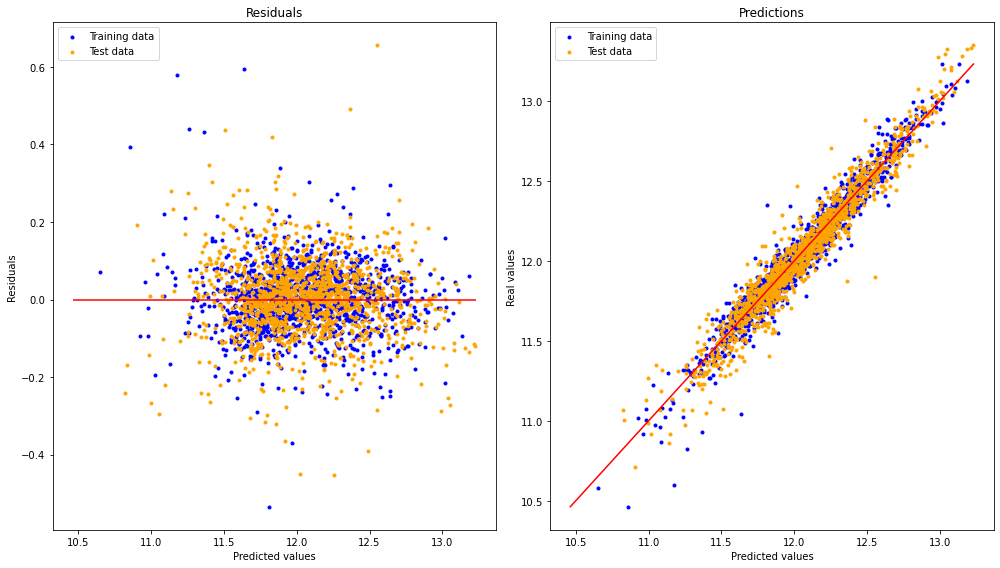

LASSO dropped 212 of 321 features.


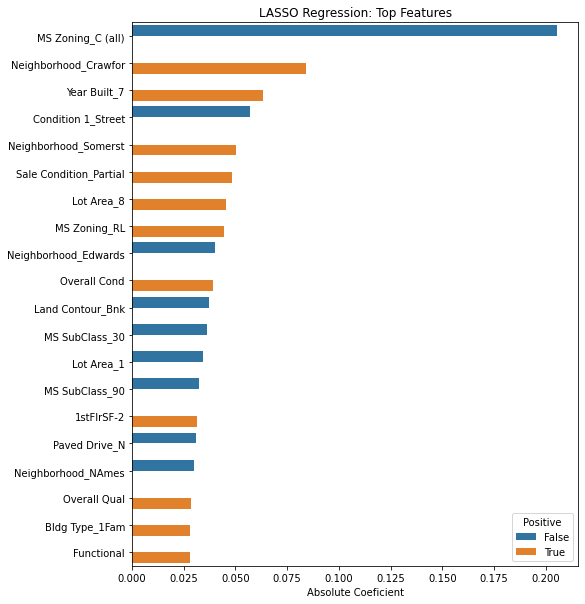

In [17]:
# 
# Run Lasso models for a range of alpha parameters and then do a gridsearch to get optimum alpha 
# 
# Switch off warnings to avoid annoying warnings
warnings.filterwarnings('ignore')

print ('\n\033[1mFull feature engineering - Lasso model - trying a number of alpha values\033[0m')
alpha=0.01
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.001
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.0005
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.0001
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.00005
run_lasso(alpha,X_train, X_test, y_train, y_test)
alpha=0.00001
run_lasso(alpha,X_train, X_test, y_train, y_test)   


final_alpha=0.0005

lasso = Lasso(alpha=final_alpha, max_iter=5000)
lasso.fit(X_train, y_train)
model_evaluation_plots(lasso, X_train, y_train, X_test, y_test)

#
# Analyse Lasso coefficients
#
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('LASSO dropped {} of {} features.'.format(sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(20)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

# Switch on warnings again
warnings.filterwarnings('default')


## Analysis of Lasso model with 'Full' feature engineering

Observations: 
   - The results for test dataset are slightly higher level compared to training dataset. Possibly due to more outliers in training dataset?    
   - Lasso algorithm does not converge easily for this dataset. Gridsearch does not complete. Possibly due to collinearity. Decided to take out.
   - Lowest RMSE for test dataset has reduced to 0.098. Limited impact of the extra effort on feature engineering.
   - Around 70% of the features get dropped by Lasso alogrithm
   - Features in top 20 have changed again. Size of the house not in top 20. Neighborhood Crawfor most important.
   - 9 features with a negative coeficient. 
   - For this Ames Housing dataset and Lasso algorithm the additional efforts on feature engineering do not improve the model performance sufficiently. 


***

# D. Comparing Lasso with KNN model
  - Compare Lasso with KNN model for a range K of nearest neighbors 

### Comparison of Lasso with KNeighborsRegressor for 'full' feature engineering

In [18]:
#
# Run KNeighborsRegressor for a range of number of neighbors on dataset with 'full' feature engineering
#
X= df_full_feat_eng.drop(columns=['SalePrice']).copy()
y= df_full_feat_eng['SalePrice'].copy() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)

def run_knn(n_neighbors,X_train, X_test, y_train, y_test):
    KNN = KNeighborsRegressor(n_neighbors=n_neighbors)
    KNN.fit(X_train, y_train)
    training_result, test_result = rmse(KNN, X_train, X_test, y_train, y_test)
    print('Model: KNeighborsRegressor  |  n_neighbors: {} \t| Train RMSE: {:.3f} | Test RMSE: {:.3f}'.
          format(n_neighbors, training_result, test_result))
    return

print ('\n\033[1mFull feature engineering - KNeighborsRegressor model - trying a number of values for number of neighbors\033[0m')

n_neighbors=1
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors=3
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors=5
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors=7
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors=9
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors=11
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors= 13
run_knn(n_neighbors,X_train, X_test, y_train, y_test)



Full feature engineering - KNeighborsRegressor model - trying a number of values for number of neighbors
Model: KNeighborsRegressor  |  n_neighbors: 1 	| Train RMSE: 0.239 | Test RMSE: 0.236
Model: KNeighborsRegressor  |  n_neighbors: 3 	| Train RMSE: 0.204 | Test RMSE: 0.210
Model: KNeighborsRegressor  |  n_neighbors: 5 	| Train RMSE: 0.199 | Test RMSE: 0.201
Model: KNeighborsRegressor  |  n_neighbors: 7 	| Train RMSE: 0.200 | Test RMSE: 0.201
Model: KNeighborsRegressor  |  n_neighbors: 9 	| Train RMSE: 0.202 | Test RMSE: 0.200
Model: KNeighborsRegressor  |  n_neighbors: 11 	| Train RMSE: 0.203 | Test RMSE: 0.200
Model: KNeighborsRegressor  |  n_neighbors: 13 	| Train RMSE: 0.203 | Test RMSE: 0.203


## Analysis of KNeighborsRegressor model with  'full' feature engineering

Observations: 
   - Much poorer result than Lasso linear regression which has a RMSE on test dataset of 0.098 whilst KNeighborsRegressor gives best result of 0.200 for 9 neighbors for 'full' feature engineering dataset

### Comparison of Lasso with KNeighborsRegressor for 'simple' feature engineering

In [19]:
#
# Run KNeighborsRegressor for a range of number of neighbors on dataset with 'simple' feature engineering
#
X= df_simple_feat_eng.drop(columns=['SalePrice']).copy()
y= np.log(df_simple_feat_eng['SalePrice']).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)

print ('\n\033[1mSimple feature engineering - KNeighborsRegressor model - trying a number of values for number of neighbors\033[0m')

n_neighbors=1
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors=3
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors=5
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors=7
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors=9
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors=11
run_knn(n_neighbors,X_train, X_test, y_train, y_test)

n_neighbors= 13
run_knn(n_neighbors,X_train, X_test, y_train, y_test)



Simple feature engineering - KNeighborsRegressor model - trying a number of values for number of neighbors
Model: KNeighborsRegressor  |  n_neighbors: 1 	| Train RMSE: 0.339 | Test RMSE: 0.293
Model: KNeighborsRegressor  |  n_neighbors: 3 	| Train RMSE: 0.279 | Test RMSE: 0.252
Model: KNeighborsRegressor  |  n_neighbors: 5 	| Train RMSE: 0.270 | Test RMSE: 0.246
Model: KNeighborsRegressor  |  n_neighbors: 7 	| Train RMSE: 0.269 | Test RMSE: 0.241
Model: KNeighborsRegressor  |  n_neighbors: 9 	| Train RMSE: 0.269 | Test RMSE: 0.244
Model: KNeighborsRegressor  |  n_neighbors: 11 	| Train RMSE: 0.270 | Test RMSE: 0.245
Model: KNeighborsRegressor  |  n_neighbors: 13 	| Train RMSE: 0.272 | Test RMSE: 0.246


## Analysis of KNeighborsRegressor model with 'Simple' feature engineering

Observations: 
   - Using 'simple' feature engineering dataset gives best result of 0.241 for 7 neighbors

***

# E. Determine minimum number of features to get a test RMSE of 0.120 using SelectKBest feature selection.

###  Run select K Best followed by Lasso for alpha=0.00 for range of K's on full feature engineering dataset

In [20]:
# Switch off warnings to avoid annoying warnings
warnings.filterwarnings('ignore')

X= df_full_feat_eng.drop(columns=['SalePrice']).copy()
y= df_full_feat_eng['SalePrice'].copy()

print ('\n\033[1mFull feature engineering - selectKbest +Lasso model - trying a number of k best values to limit number of features\033[0m')

alpha=0.0  # => Lasso = linear regression

def run_selKbest(alpha, k, X, y):
    Sel_K_Best = SelectKBest(f_regression, k=k)
    X_new = Sel_K_Best.fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.5,random_state=0)
    lasso = Lasso(alpha=alpha, max_iter=5000)
    lasso.fit(X_train, y_train)
    training_result, test_result = rmse(lasso, X_train, X_test, y_train, y_test)
    print('Model: SelectKbest + Lasso  |  Select K Best: {}| Dropped {} of {} features \t | Train RMSE: {:.3f} | Test RMSE: {:.3f}'.
          format(k, sum(lasso.coef_ ==0), len(lasso.coef_) ,training_result, test_result))
    return

k=10
run_selKbest(alpha, k, X, y)

k=30
run_selKbest(alpha, k, X, y)

k=65
run_selKbest(alpha, k, X, y)

k=75
run_selKbest(alpha, k, X, y)

k=85
run_selKbest(alpha, k, X, y)

# Switch on warnings again
warnings.filterwarnings('default')



Full feature engineering - selectKbest +Lasso model - trying a number of k best values to limit number of features
Model: SelectKbest + Lasso  |  Select K Best: 10| Dropped 0 of 10 features 	 | Train RMSE: 0.159 | Test RMSE: 0.165
Model: SelectKbest + Lasso  |  Select K Best: 30| Dropped 0 of 30 features 	 | Train RMSE: 0.126 | Test RMSE: 0.133
Model: SelectKbest + Lasso  |  Select K Best: 65| Dropped 0 of 65 features 	 | Train RMSE: 0.122 | Test RMSE: 0.126
Model: SelectKbest + Lasso  |  Select K Best: 75| Dropped 0 of 75 features 	 | Train RMSE: 0.117 | Test RMSE: 0.119
Model: SelectKbest + Lasso  |  Select K Best: 85| Dropped 0 of 85 features 	 | Train RMSE: 0.114 | Test RMSE: 0.117


## Analysis of reducing number features using Select K Best

Observations: 
   - Starting with Full feature engineering dataset we get down to around 75 features to achieve a RMSE of 0.120
   - An RMSE of 0.165 is achieved with just 10 features
   

# F. Determine min number of features to get a test RMSE of 0.120  using PCA.

###  Run PCA  followed by Lasso for alpha=0.00 for range of number of compenents on full feature engineering dataset


Full feature engineering - PCA + Lasso model - trying a number of PCA components to limit number of features
Model: PCA + Lasso  |PCA reduced num feat from 321 to 50| Dropped  0 of 50 features 	 | Train RMSE: 0.109 | Test RMSE: 0.114


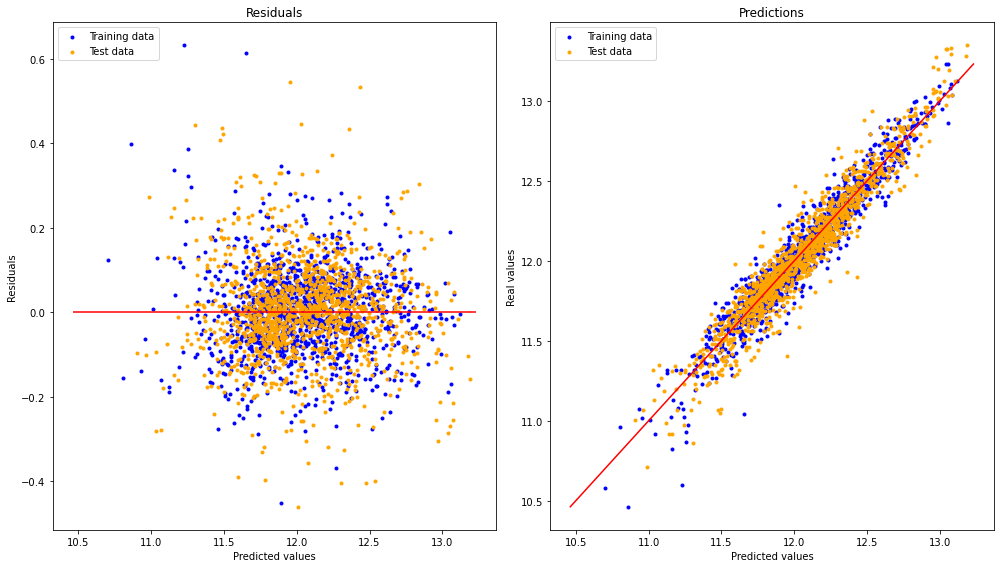

Model: PCA + Lasso  |PCA reduced num feat from 321 to 25| Dropped  0 of 25 features 	 | Train RMSE: 0.114 | Test RMSE: 0.118


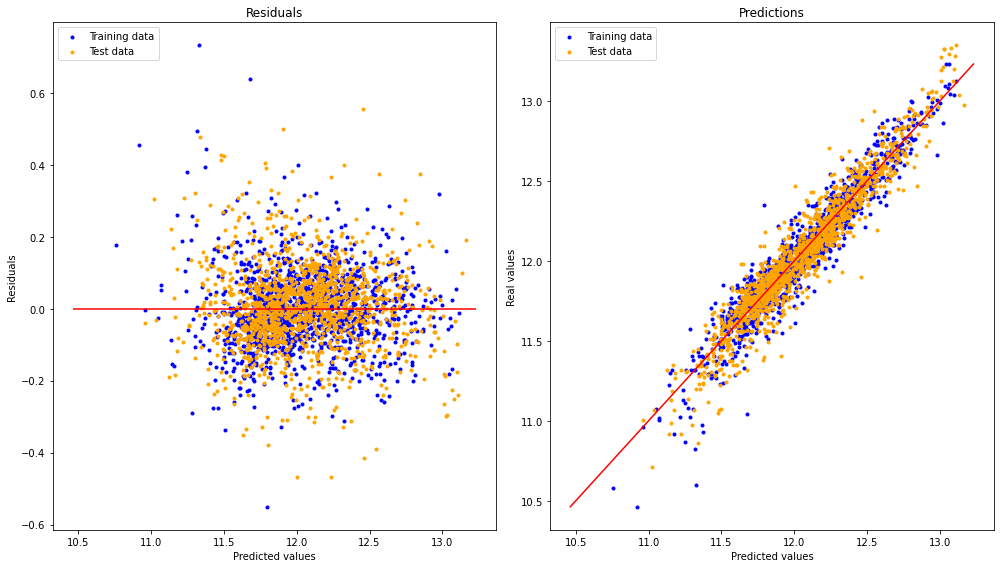

Model: PCA + Lasso  |PCA reduced num feat from 321 to 20| Dropped  0 of 20 features 	 | Train RMSE: 0.115 | Test RMSE: 0.118


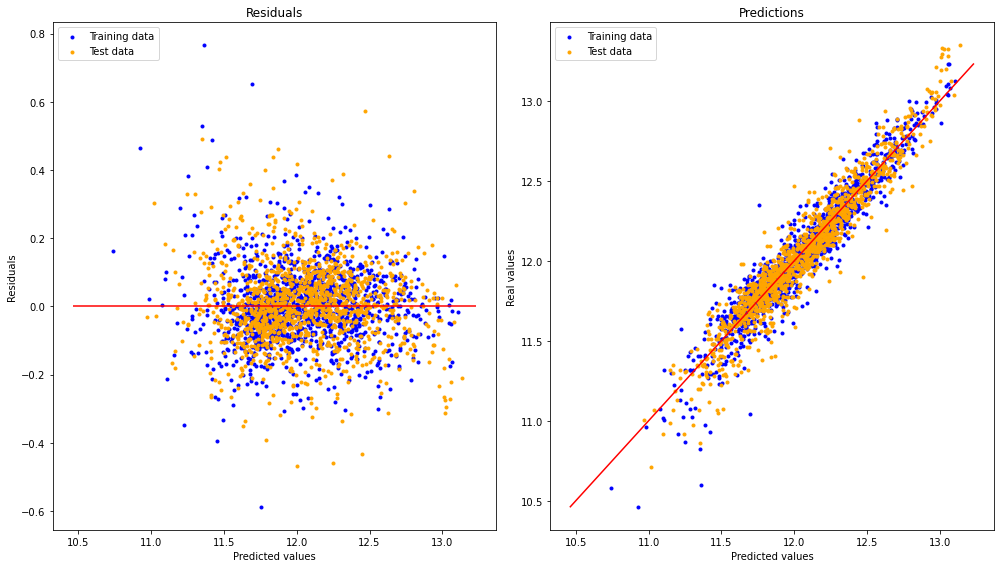

Model: PCA + Lasso  |PCA reduced num feat from 321 to 19| Dropped  0 of 19 features 	 | Train RMSE: 0.116 | Test RMSE: 0.119


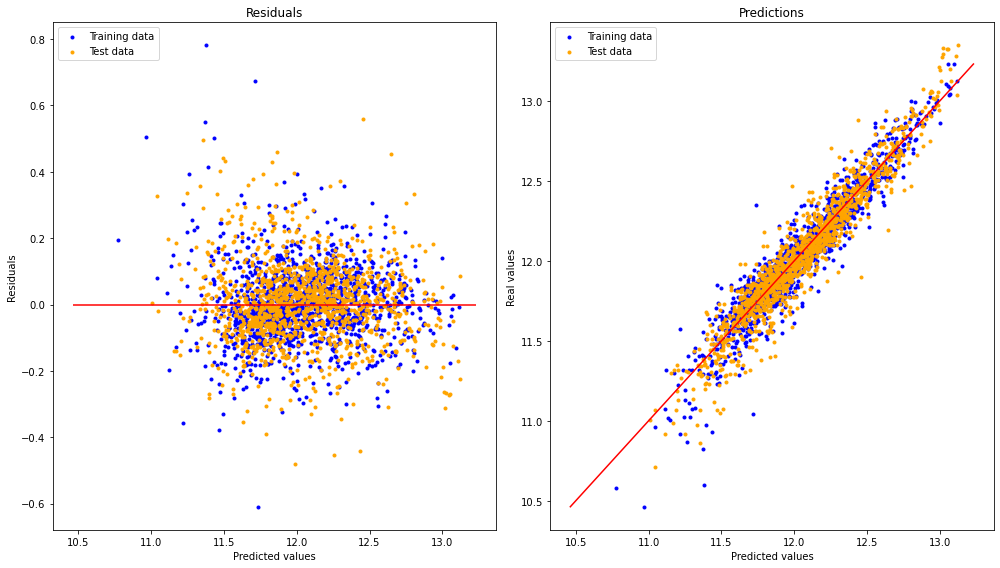

Model: PCA + Lasso  |PCA reduced num feat from 321 to 18| Dropped  0 of 18 features 	 | Train RMSE: 0.117 | Test RMSE: 0.120


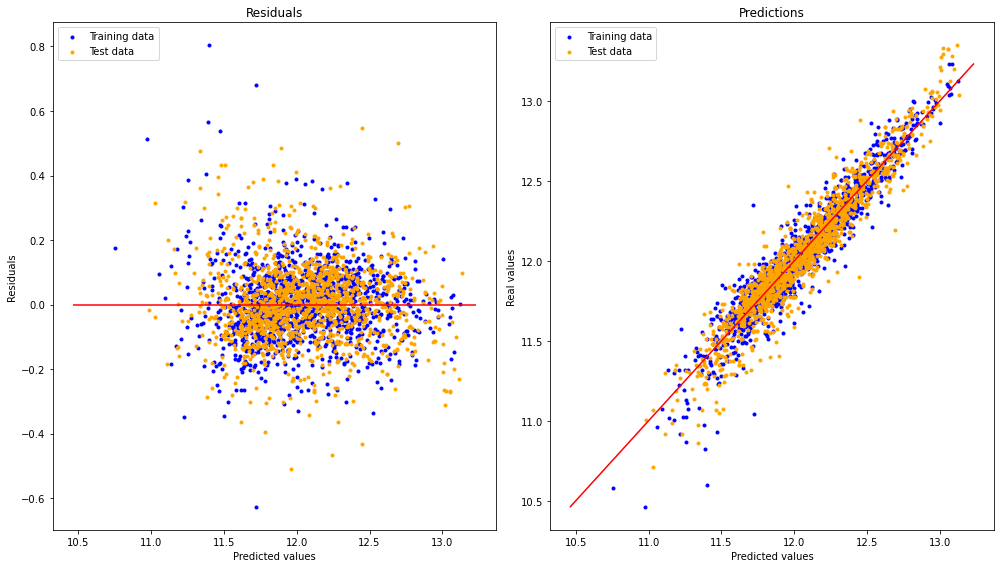

Model: PCA + Lasso  |PCA reduced num feat from 321 to 5| Dropped  0 of 5 features 	 | Train RMSE: 0.140 | Test RMSE: 0.146


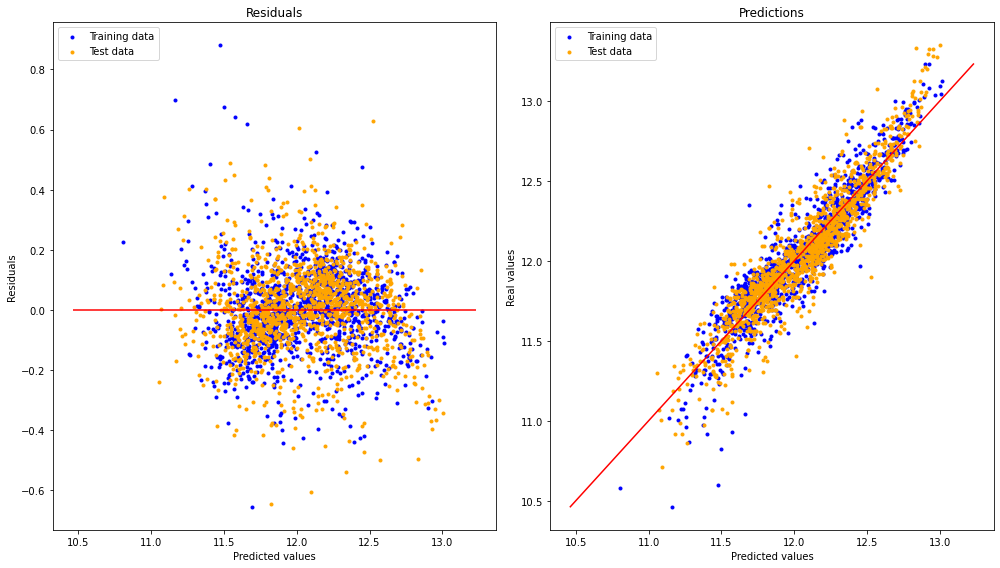

Model: PCA + Lasso  |PCA reduced num feat from 321 to 1| Dropped  0 of 1 features 	 | Train RMSE: 0.142 | Test RMSE: 0.150


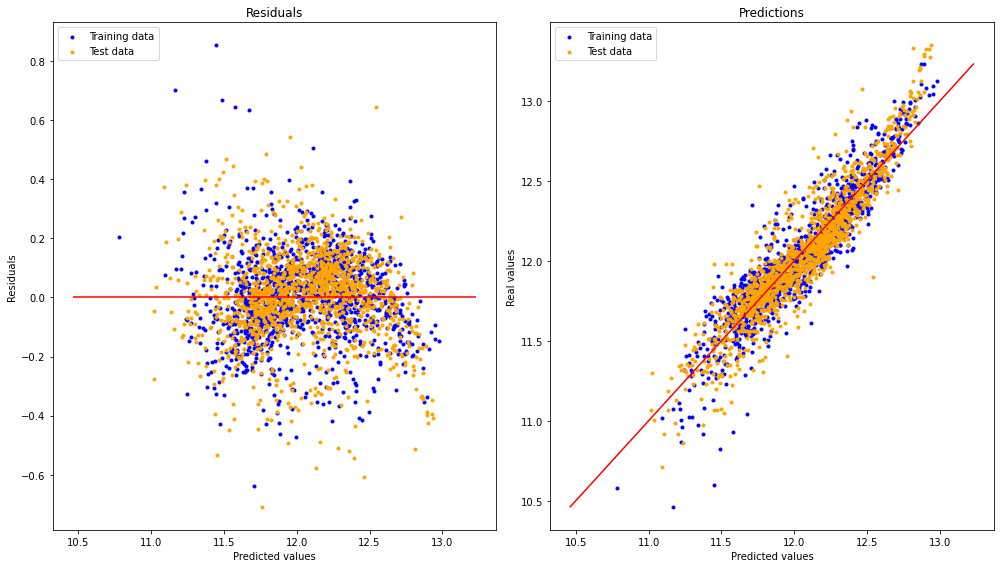

In [28]:
# Switch off warnings to avoid annoying warnings
warnings.filterwarnings('ignore')

X= df_full_feat_eng.drop(columns=['SalePrice']).copy()
y= df_full_feat_eng['SalePrice'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)

alpha=0.00

def run_pca(n_components,X_train, X_test, y_train, y_test):
    
    # Apply scaling on all features
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # Calculate PCA 
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    lasso = Lasso(alpha=alpha, max_iter=5000)
    lasso.fit(X_train_pca, y_train)
    training_result, test_result = rmse(lasso, X_train_pca, X_test_pca, y_train, y_test)
    print('Model: PCA + Lasso  |PCA reduced num feat from {} to {}| Dropped  {} of {} features \t | Train RMSE: {:.3f} | Test RMSE: {:.3f}'.
       format( X_train.shape[1], X_train_pca.shape[1],sum(lasso.coef_ ==0), len(lasso.coef_), training_result, test_result))
    model_evaluation_plots(lasso, X_train_pca, y_train, X_test_pca, y_test)
    
    return


print ('\n\033[1mFull feature engineering - PCA + Lasso model - trying a number of PCA components to limit number of features\033[0m')


n_components=50
run_pca(n_components,X_train, X_test, y_train, y_test)

n_components=25
run_pca(n_components,X_train, X_test, y_train, y_test)

n_components=20
run_pca(n_components,X_train, X_test, y_train, y_test)

n_components=19
run_pca(n_components,X_train, X_test, y_train, y_test)

n_components=18
run_pca(n_components,X_train, X_test, y_train, y_test)

n_components=5
run_pca(n_components,X_train, X_test, y_train, y_test)

n_components=1
run_pca(n_components,X_train, X_test, y_train, y_test)


# Switch on warnings again
warnings.filterwarnings('default')


## Analysis of reducing number features using PCA

Observations: 
   - Using 'full' feature engineering dataset we get down to around 18 features to achieve a RMSE of 0.120
   - An RMSE of 0.150 is achieved with 1 feature!
   

# G. Determine min number of features to get a test RMSE of 0.120 using Lasso feature selection.


Full feature engineering - Lasso model - looking for minimum number of features to achieve RMSE of 0.120
Model: Lasso |  alpha: 0.012 	| Dropped 301 of 321 features 	| Train RMSE: 0.119 | Test RMSE: 0.128


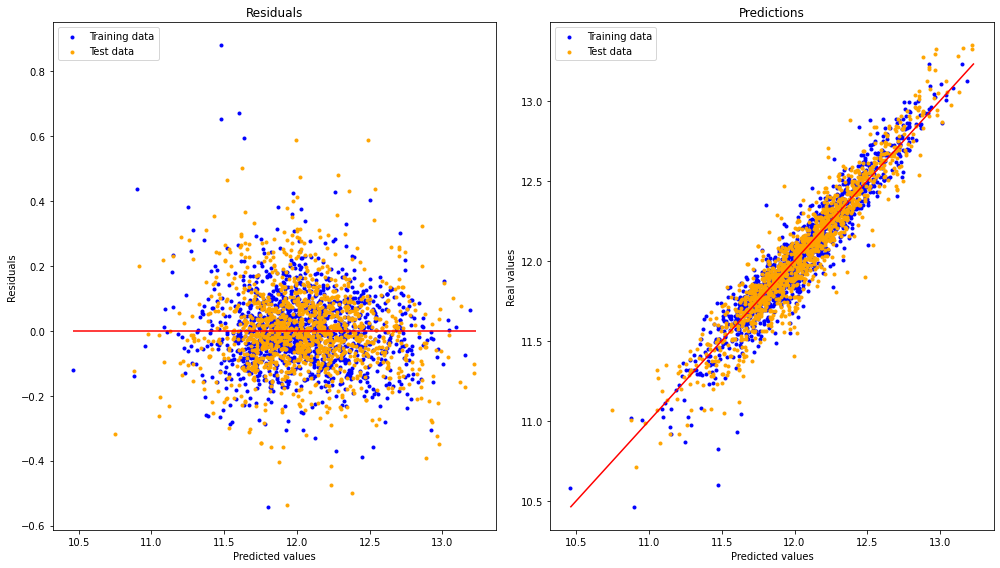

LASSO dropped 301 of 321 features.


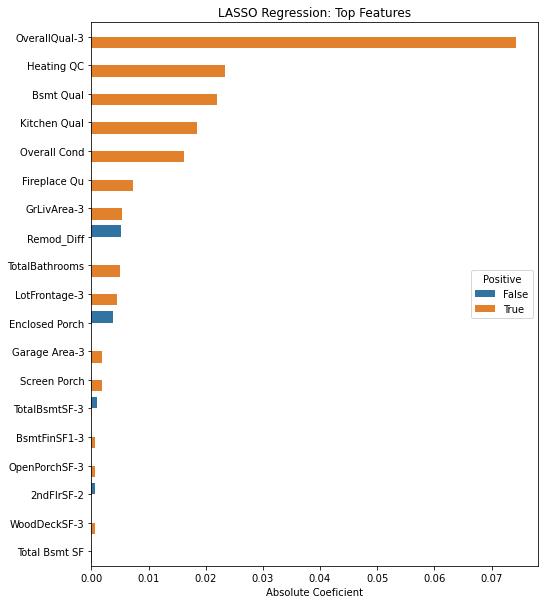

In [38]:
# Define X and y from full feature engineered dataset
X= df_full_feat_eng.drop(columns=['SalePrice']).copy()
y= df_full_feat_eng['SalePrice'].copy() # SalePrice was already log transformed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)

print ('\n\033[1mFull feature engineering - Lasso model - looking for minimum number of features to achieve RMSE of 0.120\033[0m')

# Run Lasso to achieve a RMSE of 0.128. In next cell it is demonstrated that by ....
final_alpha=0.012
run_lasso(final_alpha,X_train, X_test, y_train, y_test) # to print score

# Run again to create plot
lasso = Lasso(alpha=final_alpha, max_iter=5000)
lasso.fit(X_train, y_train)
model_evaluation_plots(lasso, X_train, y_train, X_test, y_test)

#
# Analyse Lasso coefficients
#
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('LASSO dropped {} of {} features.'.format(sum(coefs.coefs == 0), coefs.shape[0]))
top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(19)
plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()
# Selected feature list in top_coefs.index

In [39]:
#
# These are the selected 19 features
#
top_coefs.index

Index(['OverallQual-3', 'Heating QC', 'Bsmt Qual', 'Kitchen Qual',
       'Overall Cond', 'Fireplace Qu', 'GrLivArea-3', 'Remod_Diff',
       'TotalBathrooms', 'LotFrontage-3', 'Enclosed Porch', 'Garage Area-3',
       'Screen Porch', 'TotalBsmtSF-3', 'BsmtFinSF1-3', 'OpenPorchSF-3',
       '2ndFlrSF-2', 'WoodDeckSF-3', 'Total Bsmt SF'],
      dtype='object')


Full feature engineering - Lasso model - running with selected 19 features
Model: Lasso |  alpha: 1e-09 	| Dropped 0 of 19 features 	| Train RMSE: 0.113 | Test RMSE: 0.118


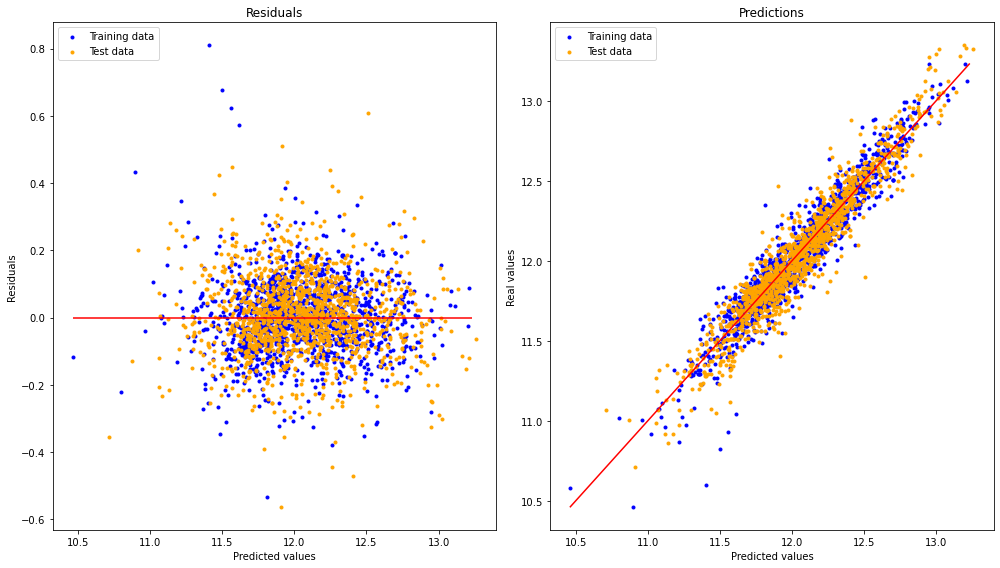

LASSO dropped 0 of 19 features.


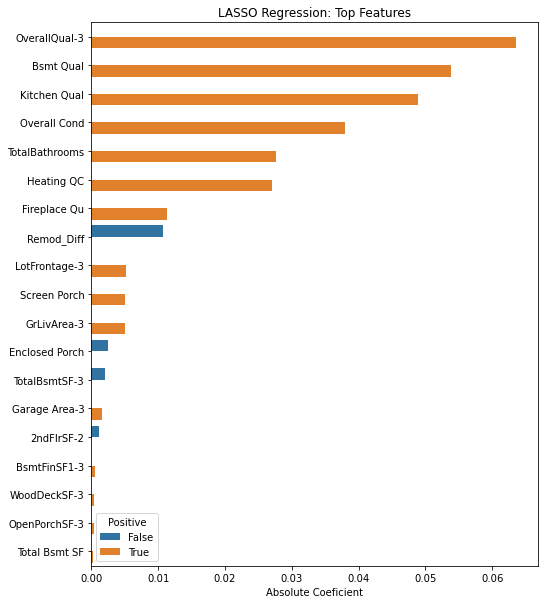

In [40]:
#
#  Select 19 columns and copy to X dataframe and rerun analysis to verify score for these 19 features
#
X= df_full_feat_eng[top_coefs.index].copy()
y= df_full_feat_eng['SalePrice'].copy() # SalePrice was already log transformed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)

print ('\n\033[1mFull feature engineering - Lasso model - running with selected 19 features\033[0m')
final_alpha=0.000000001
run_lasso(final_alpha,X_train, X_test, y_train, y_test)

lasso = Lasso(alpha=final_alpha, max_iter=5000)
lasso.fit(X_train, y_train)
model_evaluation_plots(lasso, X_train, y_train, X_test, y_test)

#
# Analyse Lasso coefficients
#
coefs = pd.DataFrame({'coefs':lasso.coef_,'Positive':lasso.coef_ > 0}, index=X_train.columns)
coefs['coefs_abs'] = np.abs(coefs.coefs)
print('LASSO dropped {} of {} features.'.format(sum(coefs.coefs == 0), coefs.shape[0]))

top_coefs = coefs.sort_values('coefs_abs', ascending=False).head(25)

plt.figure(figsize=(8,10))
sns.barplot( top_coefs.coefs_abs, top_coefs.index, orient='h', hue=top_coefs.Positive)
plt.title('LASSO Regression: Top Features')
plt.xlabel('Absolute Coeficient')
plt.show()

## Analysis of reducing number features using Lasso for feature selection

Observations: 
   - Using 'full' feature engineering dataset we tested for an alpha to get an RMSE of 0.128. This resulted in 19 features. To test and get final score we created a new dataset with only these columns and obtained a final RMSE of 0.119 using the selected 19 features. It is not clear why the final RMSE for this subset is lower than in the previous run using the full dataset.
   - Quality and condition features are ranking high. No neigborhood features. Some features linked to area of house and garden.